# BENG0095 Project

## Introduction [CHANGE]

In this notebook we will explore various binary classification algortihms, including Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), Logistic Regression, and Naive Bayes. 

We will apply these algorithms to one toy data set, and two real-world datasets: the Pima Indians Diabetes data set; and the Wisconsin Diagnostic Breast Cancer data set. 

We will evaluate performances using three metrics: Classifcation Accuracy, the Receiver Operating Characteristic, and Precision/Recall scores.

## Imports

We start by importing all relevant packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from os import chdir
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize

# you may need to import sklearn.lda.LDA and sklearn.qda.QDA instead
# depending on which version you have installed
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, classification_report, ConfusionMatrixDisplay, auc

## Test Dataset

We start processing the


The International Match History Dataset compiles football match results of between national teams between 2004-09-03 and 2021-12-18.

The dataset contains data from 5,641 matches with 25 features:

1. Date
2. Home team (HT)
3. Away team (AT)
4. HT continent
5. AT continent
6. HT FIFA rank
7. AT FIFA rank
8. HT total FIFA points
9. AT total FIFA points
10. HT score
11. AT score
12. Tournament
13. City
14. Country
15. Neutral location
16. Shoot out
17. HT result
18. HT goalkeeper score
19. AT goalkeeper score
20. HT defense score
21. HT offense score
22. HT midfield score
23. AT defense score
24. AT offense score
25. AT midfield score

## International Match History Dataset

The International Match History Dataset compiles football match results of between national teams between 2004-09-03 and 2021-12-18.

The dataset contains data from 5,641 matches with 25 features:

1. Date
2. Home team (HT)
3. Away team (AT)
4. HT continent
5. AT continent
6. HT FIFA rank
7. AT FIFA rank
8. HT total FIFA points
9. AT total FIFA points
10. HT score
11. AT score
12. Tournament
13. City
14. Country
15. Neutral location
16. Shoot out
17. HT result
18. HT goalkeeper score
19. AT goalkeeper score
20. HT defense score
21. HT offense score
22. HT midfield score
23. AT defense score
24. AT offense score
25. AT midfield score

### Loading the dataset

We first load the dataset and visualise it to understand it better

In [2]:
# changing directory to current working directory
import os 
chdir(os.getcwd())

# reading raw .csv file
data = pd.read_csv('dataset/match_history.csv')

# loading test_set
test_set = pd.read_csv('dataset/test_set.csv')
test_set['date'] = pd.to_datetime(test_set['date']).dt.date

# date is imported as string, we change to datetime for easier cleaning
data['date'] = pd.to_datetime(data['date']).dt.date

In [3]:
# visualising first 5 rows
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


### Plotting correlations

In order to understand better the numerical data before processing it, we want to see if any variables are particularly correlated.

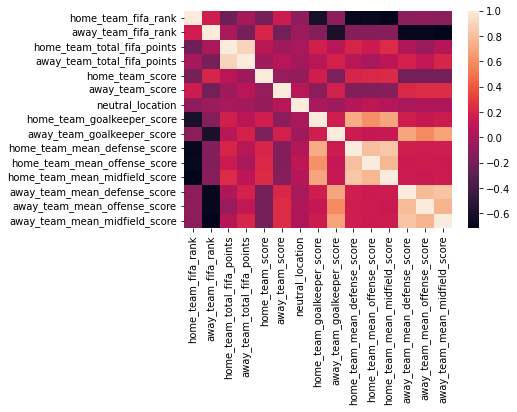

In [4]:
# compute correlations between features
corr = data.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

### _Takeaways_

1. Scores of different positions within the same team and same match are highly positively correlated.
2. Team FIFA rank and positions' scores are highly negatively correlated.

### Plotting features - Histogram

To understand data further, we plot histograms of all numerical features.

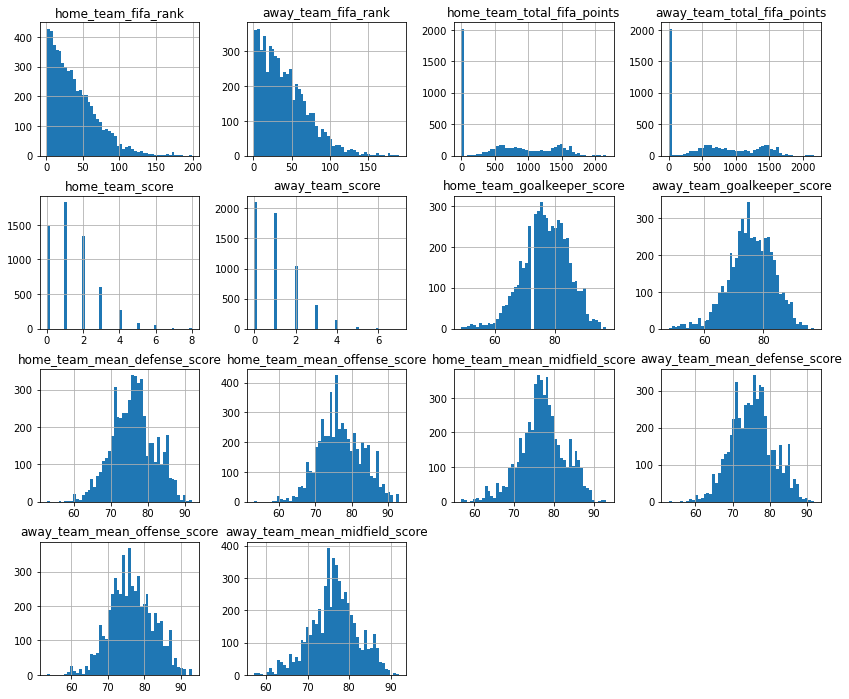

In [5]:
data.hist(bins=50, figsize=(14, 12))
plt.show()

### _Takeaways_

1. FIFA points columns (_home_team_total_fifa_points_ and _away_team_total_fifa_points_) have a large number of zeroes, which seems like a problem with the data and needs to be investigated further.
2. _home_team_goalkeeper_score_ seems to have a gap at around 72.
3. Most other data roughly follows normal distributions.

### Probing FIFA points

In order to clean the data, we first need to understand why there are large numbers of zero values in the FIFA points columns.

In [6]:
# select all rows where home team fifa points is zero
zero_points = data.query('home_team_total_fifa_points == 0')
zero_points.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


In [7]:
# printing them in descending order by date
zero_points.sort_values(by = 'date', ascending=False).head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2016,2011-08-10,Wales,Australia,Europe,Oceania,112,22,0,0,1,...,No,Lose,75.0,80.0,74.2,71.0,80.2,72.5,76.7,71.0
2001,2011-08-10,Israel,Côte d'Ivoire,Europe,Africa,32,15,0,0,3,...,No,Lose,78.0,72.0,67.0,69.0,73.8,75.8,83.3,77.2
1989,2011-08-10,Austria,Slovakia,Europe,Europe,66,29,0,0,1,...,No,Lose,75.0,72.0,74.0,74.0,74.8,74.8,77.3,74.2
1990,2011-08-10,Belarus,Bulgaria,Europe,Europe,42,48,0,0,1,...,No,Win,75.0,77.0,63.0,71.0,72.2,71.2,75.3,75.0
1991,2011-08-10,Bosnia and Herzegovina,Greece,Europe,Europe,41,13,0,0,0,...,No,Draw,76.0,74.0,72.5,78.3,77.5,75.5,76.3,75.5


Interesting... All zero values seem to be between the dates of 2004-09-03 and 2011-08-10.

We need to make sure that all values between these dates are zero.

In [8]:
# printing all values not equal to zero and lower than the upper boundary (home team)
nonzero_points = data.query('home_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


In [9]:
# printing all values not equal to zero and lower than the upper boundary (away team)
nonzero_points = data.query('away_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


We found something! It seems like the dataset is missing values for the fifa points before 2011-08-10, this will need to be cleaned up

### Data Cleansing

Now that we understand the data better, it is time to clean it up before training the model.

### Position scores

From printing the first few values of the data, we also realised there were some null (or NaN) values at in the columns displaying the scores of the different positions (home team defense, away team goalkeeper, etc).

Nonetheless, as seen in the correlations diagram, there is a strong correlation between one position's score and the score of the other positions (within the same match). Therefore, we have chosen to fill in the NaN values with the average of the other positions within the team each match.

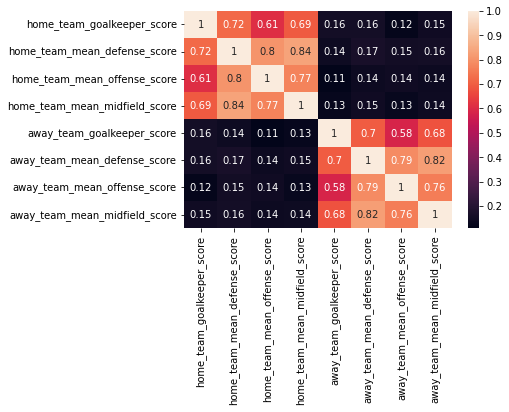

In [10]:
# compute correlations between team points
corr = data[['home_team_goalkeeper_score', \
             'home_team_mean_defense_score', \
             'home_team_mean_offense_score',\
             'home_team_mean_midfield_score', \
             'away_team_goalkeeper_score', \
             'away_team_mean_defense_score', \
             'away_team_mean_offense_score', \
             'away_team_mean_midfield_score']].corr()

heatmap(corr, annot=True)

plt.show()

In [11]:
# remember NaN values are ignored when calculating the average
home_mean = data[['home_team_goalkeeper_score', \
                  'home_team_mean_defense_score', \
                  'home_team_mean_offense_score',\
                  'home_team_mean_midfield_score']].mean(axis=1)

home_mean.head()

0    89.825
1    66.750
2    76.550
3    78.800
4    82.000
dtype: float64

In [12]:
clean_data = data
for i, col in enumerate(clean_data):
    clean_data.iloc[:, i] = data.iloc[:, i].fillna(home_mean)
    
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


In [13]:
# checking if there are any remaining NaN values
data_nan = clean_data[clean_data.isna().any(axis=1)]
data_nan.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


Perfect! As we can see we have been able to replace all NaN values in the position scores section with the averages of the teams' scores.

### FIFA points cleanup

Given the values equal to zero in the FIFA points columns, we want to understand better how to get clean them.

In [14]:
# indentifying the data with FIFA points
mask = clean_data['date'] > dt.date(2011, 8, 10)
data_post2011 = clean_data.loc[mask]

data_post2011.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2017,2011-08-27,Angola,Congo DR,Africa,Africa,96,127,338,221,1,...,No,Lose,70.0,67.066667,67.066667,69.7,61.5,69.2,69.7,70.0
2018,2011-09-02,Albania,France,Europe,Europe,57,15,546,918,1,...,No,Lose,70.0,86.000000,70.400000,69.7,71.5,82.5,83.0,84.5
2019,2011-09-02,Argentina,Venezuela,South America,South America,9,44,1016,615,1,...,No,Win,77.0,64.000000,80.800000,88.3,85.2,72.2,73.7,75.5
2020,2011-09-02,Belarus,Bosnia and Herzegovina,Europe,Europe,41,39,645,655,0,...,No,Lose,75.0,76.000000,63.200000,67.3,68.0,72.0,77.7,78.0
2021,2011-09-02,Bulgaria,England,Europe,Europe,51,4,585,1176,0,...,No,Lose,80.0,83.000000,70.800000,73.7,73.5,84.0,81.3,85.8


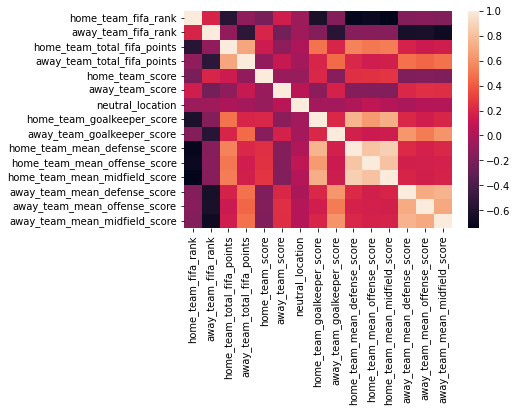

In [15]:
corr = data_post2011.corr()

heatmap(corr)

plt.show()

Interesting... it seems like there are some higher correlations between FIFA rank and FIFA points when data is nonzero.

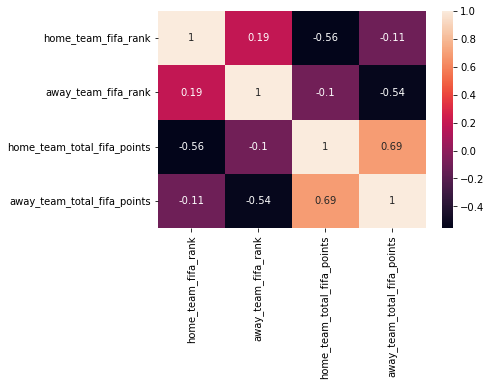

In [16]:
# compute correlations between features
corr = data_post2011[['home_team_fifa_rank', \
                      'away_team_fifa_rank', \
                      'home_team_total_fifa_points', \
                      'away_team_total_fifa_points']].corr()

heatmap(corr, annot=True)

plt.show()

Given the high correlation between FIFA rank and FIFA points, it seems like we can drop the FIFA points column with little impact on the performance of the model.

In [17]:
clean_data = clean_data.drop(columns=['home_team_total_fifa_points','away_team_total_fifa_points'])
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_score,away_team_score,tournament,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,1,1,Friendly,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,2,1,FIFA World Cup qualification,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,2,2,FIFA World Cup qualification,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,3,0,FIFA World Cup qualification,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,1,1,FIFA World Cup qualification,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


### Other cleanup

In order to feed the model the right data, we clean up further by dropping the date, continents, tournament, city, country and neutral location.

In [18]:
clean_data1 = clean_data

In [19]:
# Continents
clean_data1['home_team_continent'].unique()

array(['Europe', 'Africa', 'South America', 'North America', 'Oceania',
       'Asia'], dtype=object)

In [20]:
clean_data1['home_team_continent'] = clean_data1['home_team_continent'].map({'Europe':1, \
                                                                             'Africa':2, \
                                                                             'South America':3, \
                                                                             'North America':4, \
                                                                             'Oceania':5, \
                                                                             'Asia':6})
clean_data1['away_team_continent'] = clean_data1['away_team_continent'].map({'Europe':1, \
                                                                             'Africa':2, \
                                                                             'South America':3, \
                                                                             'North America':4, \
                                                                             'Oceania':5, \
                                                                             'Asia':6})

In [21]:
# Tournament
clean_data1['tournament'].unique()

array(['Friendly', 'FIFA World Cup qualification', "King's Cup",
       'CFU Caribbean Cup', 'Confederations Cup', 'Gold Cup',
       'EAFF Championship', 'African Cup of Nations',
       'Lunar New Year Cup', 'Cyprus International Tournament',
       'Kirin Cup', 'FIFA World Cup', 'UEFA Euro qualification',
       'African Cup of Nations qualification', 'Copa del Pacífico',
       'Copa América', 'AFC Asian Cup', 'UEFA Euro', 'COSAFA Cup',
       'Baltic Cup', 'UNCAF Cup', 'Nations Cup', 'Copa Confraternidad',
       'Superclásico de las Américas', 'Nehru Cup',
       'African Nations Championship', 'Kirin Challenge Cup', 'OSN Cup',
       'CFU Caribbean Cup qualification', 'Intercontinental Cup',
       'UEFA Nations League',
       'African Nations Championship qualification',
       'CONCACAF Nations League', 'Arab Cup'], dtype=object)

In [22]:
clean_data1['tournament'] = (clean_data1['tournament'] == 'Friendly').astype(int) # 1 Friendly 0 Else

In [23]:
# Drop city and country
clean_data1 = clean_data1.drop(columns=['city', 'country'])

In [24]:
# Neutral location
clean_data1['neutral_location'].unique()

array([False,  True])

In [25]:
clean_data1['neutral_location'] = clean_data1['neutral_location'].map({True:1, False:0})

In [26]:
# Shoot out
clean_data1['shoot_out'].unique()

array(['No', 'Yes'], dtype=object)

In [27]:
# if shoot out then equivalent to Draw in world cup group stage
clean_data1['home_team_result'] = np.where(clean_data1['shoot_out']=='Yes', 'Draw', clean_data1['home_team_result'])
clean_data1 = clean_data1.drop(columns=['shoot_out'])

In [28]:
# Home team result
clean_data1['home_team_result'].unique()

array(['Draw', 'Win', 'Lose'], dtype=object)

In [29]:
clean_data1['home_team_result'] = clean_data1['home_team_result'].map({'Win':1, 'Draw':0, 'Lose':-1})

In [30]:
clean_data1 = clean_data1.drop(columns=['home_team_score','away_team_score'])

In [31]:
clean_data1.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,1,1,3,67,1,0,0,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,1,1,94,14,0,0,1,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,1,1,90,7,0,0,0,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,1,1,25,76,0,0,1,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,1,1,15,87,0,0,0,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


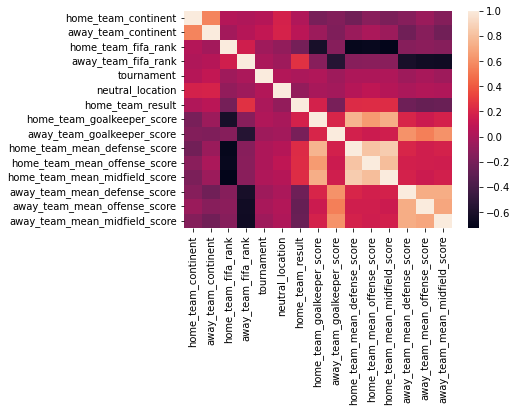

In [32]:
corr = clean_data1.corr()

heatmap(corr)

plt.show()

In [33]:
clean_data1 = clean_data1.drop(columns=['home_team_continent','away_team_continent'])

In [34]:
# copy final clean data with date for later use, remove for algorithms. Create clean_data2 for later use
date_data = clean_data1
clean_data2 = clean_data1
date_data = clean_data1
clean_data1 = clean_data1.drop(columns=['date'])

In [35]:
clean_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team                      5641 non-null   object 
 1   away_team                      5641 non-null   object 
 2   home_team_fifa_rank            5641 non-null   int64  
 3   away_team_fifa_rank            5641 non-null   int64  
 4   tournament                     5641 non-null   int64  
 5   neutral_location               5641 non-null   int64  
 6   home_team_result               5641 non-null   int64  
 7   home_team_goalkeeper_score     5641 non-null   float64
 8   away_team_goalkeeper_score     5641 non-null   float64
 9   home_team_mean_defense_score   5641 non-null   float64
 10  home_team_mean_offense_score   5641 non-null   float64
 11  home_team_mean_midfield_score  5641 non-null   float64
 12  away_team_mean_defense_score   5641 non-null   f

## Training and validation

[CHANGE]

### Split the Data Set

Before we start, we need to split the data set into a training set and a validation set, as well as selecting the relevant columns.

In [36]:
# convert team names into dummy/indicator variables
clean_data1 = pd.get_dummies(clean_data1)
# add Qatar
clean_data1 = clean_data1.assign(away_team_Qatar=np.zeros(5641, dtype=int))
clean_data1 = clean_data1.assign(home_team_Qatar=np.zeros(5641, dtype=int))

# extract match result from dataset
X = clean_data1.drop('home_team_result', axis=1)
y = clean_data1['home_team_result']

# split the dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33)
#X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=33)

### Scale the Data Set:
Next we standardise the data set since the features are reported on different scales. 

Common scaling techniques include normalisation and binarisation. 

`sklearn.preprocessing` provides various feature scaling modules (use `help(preprocessing)` to check the documentation of these modules). 

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [38]:
random_state = np.random.RandomState(33)

We will now apply 9 algorithms to obtain results:
1. 

### _Logistic Regression_

              precision    recall  f1-score   support

          -1       0.47      0.50      0.49       321
           0       0.31      0.11      0.16       321
           1       0.55      0.75      0.64       487

    accuracy                           0.50      1129
   macro avg       0.44      0.46      0.43      1129
weighted avg       0.46      0.50      0.46      1129



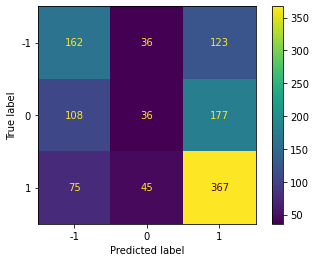

In [39]:
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train, y_train)
y_lr = lr.predict(X_val)

y_lr_prob = lr.predict_proba(X_val)[:, -1]  # probability estimates of the positive class
y_lr_score = lr.decision_function(X_val)    # confidence scores

print(classification_report(y_val,y_lr))
ConfusionMatrixDisplay.from_predictions(y_val,y_lr);

### _Naive Bayes_

              precision    recall  f1-score   support

          -1       0.47      0.13      0.21       321
           0       0.28      0.88      0.43       321
           1       0.69      0.07      0.12       487

    accuracy                           0.32      1129
   macro avg       0.48      0.36      0.25      1129
weighted avg       0.51      0.32      0.23      1129



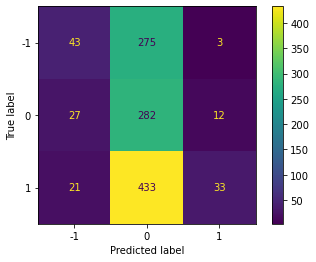

In [40]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_nb = nb.predict(X_val)

print(classification_report(y_val,y_nb))
ConfusionMatrixDisplay.from_predictions(y_val,y_nb);

### _Linear Discriminant Analysis (LDA)_

              precision    recall  f1-score   support

          -1       0.48      0.50      0.49       321
           0       0.34      0.14      0.19       321
           1       0.55      0.75      0.63       487

    accuracy                           0.50      1129
   macro avg       0.45      0.46      0.44      1129
weighted avg       0.47      0.50      0.47      1129



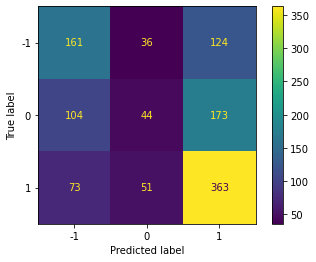

In [41]:
lda = LDA()
lda.fit(X_train, y_train)
y_lda = lda.predict(X_val)

print(classification_report(y_val,y_lda))
ConfusionMatrixDisplay.from_predictions(y_val,y_lda);

### _Quadratic Discriminant Analysis (QDA)_

/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

          -1       0.34      0.44      0.38       321
           0       0.27      0.47      0.34       321
           1       0.57      0.17      0.26       487

    accuracy                           0.33      1129
   macro avg       0.39      0.36      0.33      1129
weighted avg       0.42      0.33      0.32      1129



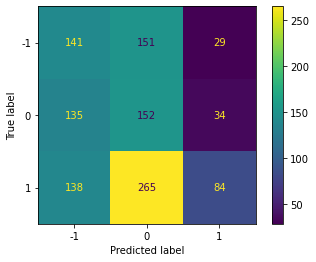

In [42]:
qda = QDA()
qda.fit(X_train, y_train)
y_qda = qda.predict(X_val)

print(classification_report(y_val,y_qda))
ConfusionMatrixDisplay.from_predictions(y_val,y_qda);

### _Random Forest Classifier (RFC)_

              precision    recall  f1-score   support

          -1       0.47      0.49      0.48       321
           0       0.27      0.09      0.14       321
           1       0.53      0.75      0.62       487

    accuracy                           0.49      1129
   macro avg       0.42      0.44      0.41      1129
weighted avg       0.44      0.49      0.44      1129



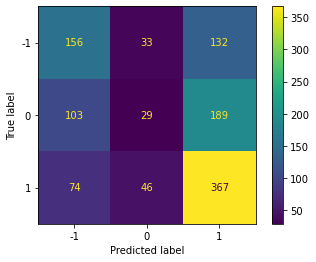

In [43]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc = rfc.predict(X_val)

print(classification_report(y_val,y_rfc))
ConfusionMatrixDisplay.from_predictions(y_val,y_rfc);

### _Support Vector Classifier (SVC)_

              precision    recall  f1-score   support

          -1       0.48      0.47      0.47       321
           0       0.30      0.07      0.11       321
           1       0.52      0.79      0.63       487

    accuracy                           0.49      1129
   macro avg       0.43      0.44      0.40      1129
weighted avg       0.44      0.49      0.44      1129



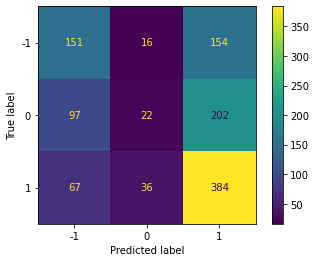

In [44]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', random_state=random_state)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_val)

print(classification_report(y_val,y_svc))
ConfusionMatrixDisplay.from_predictions(y_val,y_svc);

### _Decision Tree Classifier_

              precision    recall  f1-score   support

          -1       0.36      0.41      0.38       321
           0       0.27      0.23      0.25       321
           1       0.51      0.51      0.51       487

    accuracy                           0.40      1129
   macro avg       0.38      0.39      0.38      1129
weighted avg       0.40      0.40      0.40      1129



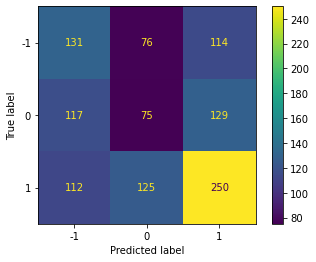

In [45]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', random_state=random_state)
dtc.fit(X_train, y_train)
y_dtc = dtc.predict(X_val)

print(classification_report(y_val,y_dtc))
ConfusionMatrixDisplay.from_predictions(y_val,y_dtc);

### _Adaptive Boosting Classifier_

              precision    recall  f1-score   support

          -1       0.44      0.54      0.49       321
           0       0.25      0.04      0.07       321
           1       0.53      0.75      0.62       487

    accuracy                           0.49      1129
   macro avg       0.41      0.44      0.39      1129
weighted avg       0.43      0.49      0.43      1129



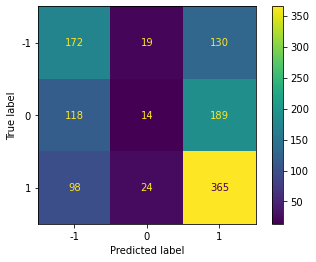

In [46]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
y_abc = abc.predict(X_val)

print(classification_report(y_val,y_abc))
ConfusionMatrixDisplay.from_predictions(y_val,y_abc);

### _Multi-Layer Perceptron (MLP)_

              precision    recall  f1-score   support

          -1       0.48      0.54      0.51       321
           0       0.27      0.01      0.02       321
           1       0.54      0.83      0.65       487

    accuracy                           0.51      1129
   macro avg       0.43      0.46      0.39      1129
weighted avg       0.44      0.51      0.43      1129



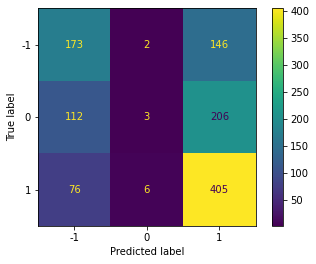

In [47]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=15, max_iter=1000000)
mlp.fit(X_train, y_train)
y_mlp = mlp.predict(X_val)

print(classification_report(y_val,y_mlp))
ConfusionMatrixDisplay.from_predictions(y_val,y_mlp);

,LR,NB,LDA,QDA,RFC,SVC,DTC,ABC,MLP
0,0.500443,0.317095,0.5031,0.333924,0.488928,0.493357,0.403897,0.488043,0.514615


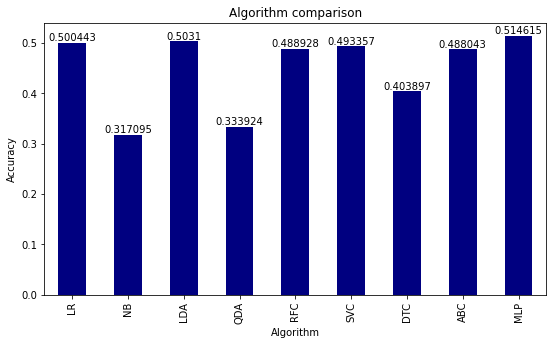

In [48]:
# create a dictionary variable with keys being algorithms names and values being classification predictions
results = dict(zip(['LR', 'NB', 'LDA', 'QDA', 'RFC', 'SVC', 'DTC', 'ABC', 'MLP'], \
                   [y_lr, y_nb, y_lda, y_qda, y_rfc, y_svc, y_dtc, y_abc, y_mlp]))

# create a dictionary variable with keys being algorithm names and values being classification accuracy
accuracy = {}
for algorithm, prediction in results.items():
    accuracy[algorithm] = accuracy_score(y_val, prediction)
    
accuracy = pd.DataFrame(data=accuracy, index=[0])
ax = accuracy.T.plot.bar(
    title='Algorithm comparison',
    xlabel='Algorithm',
    ylabel='Accuracy',
    color='navy',
    figsize=(9, 5),
    legend=False,
)
ax.bar_label(ax.containers[0])

accuracy

### ROC Curve
A Receiver Operating Characteristic curve (ROC curve) is a graphical plot of the true positive rate (TPR) against the false positive rate (FPR), using different threshold settings:

In [49]:
# binarise output
y_train_bin = label_binarize(y_train, classes=[-1, 0, 1])
y_val_bin = label_binarize(y_val, classes=[-1, 0, 1])

# learn to predict each class against the other, using MLP which was the most accurate model
classifier = OneVsRestClassifier(MLPClassifier(alpha=15, max_iter=1000000))
y_score = classifier.fit(X_train, y_train_bin).predict_proba(X_val)

# compute ROC curve and area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in [-1, 0, 1]:
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

We now proceed to compute and plot the micro and macro averages.

In [50]:
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in [-1, 0, 1]]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in [-1, 0, 1]:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

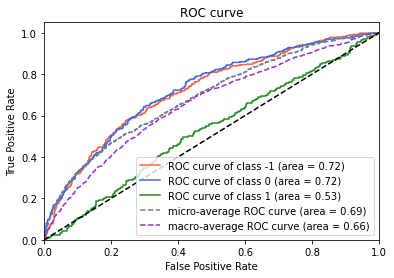

In [51]:
# plotting results   
plt.figure()

# curves for each class
plt.plot(
    fpr[-1],
    tpr[-1],
    color='tomato',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(-1, roc_auc[-1]),
)
plt.plot(
    fpr[0],
    tpr[0],
    color='royalblue',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(0, roc_auc[0]),
)
plt.plot(
    fpr[1],
    tpr[1],
    color='forestgreen',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(1, roc_auc[1]),
)

# curves for micro and macro averages
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="slategrey",
    linestyle="--",
)
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="darkorchid",
    linestyle="--",
)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

## Prediction

[CHANGE]

### Building missing features
First we need to build the missing features into the prediction dataset in order to feed the model the correct inputs.

In [52]:
# reading raw .csv file
pred_data = pd.read_csv('dataset/worldcup_2022.csv')

# date is imported as string, we change to datetime for easier cleaning
pred_data['date'] = pd.to_datetime(pred_data['date']).dt.date

pred_data.tail()

,date,home_team,away_team
43,2022-12-01,Costa Rica,Germany
44,2022-12-02,Ghana,Uruguay
45,2022-12-02,Korea Republic,Portugal
46,2022-12-02,Serbia,Switzerland
47,2022-12-02,Cameroon,Brazil


In [53]:
# filling in tournament and neutral location features
pred_data = pred_data.assign(tournament=np.zeros(48, dtype=int))

# Qatar plays in indices 0 and 35
nloc = np.full(48, 1)
nloc[0], nloc[35] = 0, 0
pred_data = pred_data.assign(neutral_location=nloc)

pred_data.head()

,date,home_team,away_team,tournament,neutral_location
0,2022-11-20,Qatar,Ecuador,0,0
1,2022-11-21,Senegal,Netherlands,0,1
2,2022-11-21,England,IR Iran,0,1
3,2022-11-21,USA,Wales,0,1
4,2022-11-22,France,Australia,0,1


Since the tournament is not friendly, we assign 0 to all values in the feature (as with `clean_data1`).

Similarly, neutral location is only False (0) for Qatar.

In [54]:
# filling in tournament and neutral location features
pred_data = pred_data.assign(tournament=np.zeros(48, dtype=int))

# Qatar plays in indices 0 and 35
nloc = np.full(48, 1)
nloc[0], nloc[35] = 0, 0
pred_data = pred_data.assign(neutral_location=nloc)

pred_data.head()

,date,home_team,away_team,tournament,neutral_location
0,2022-11-20,Qatar,Ecuador,0,0
1,2022-11-21,Senegal,Netherlands,0,1
2,2022-11-21,England,IR Iran,0,1
3,2022-11-21,USA,Wales,0,1
4,2022-11-22,France,Australia,0,1


In [55]:
# initialise remaining features
pred_data = pred_data.assign(home_team_fifa_rank=np.zeros(48, dtype=int))
pred_data = pred_data.assign(away_team_fifa_rank=np.zeros(48, dtype=int))
pred_data = pred_data.assign(home_team_goalkeeper_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_goalkeeper_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_defense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_offense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_midfield_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_defense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_offense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_midfield_score=np.zeros(48, dtype=float))

pred_data.head()

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-11-21,Senegal,Netherlands,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-11-21,England,IR Iran,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-11-21,USA,Wales,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-11-22,France,Australia,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now have all the features we need initialised, but still need to fill in the relevant values for team ranks and positions' scores.

We do this by finding the scores of the last match each country played.

In [56]:
# finding all countries that play in the world cup
countries_22 = np.unique(pred_data[['home_team', 'away_team']].values)
countries_22

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'IR Iran', 'Japan', 'Korea Republic',
       'Mexico', 'Morocco', 'Netherlands', 'Poland', 'Portugal', 'Qatar',
       'Saudi Arabia', 'Senegal', 'Serbia', 'Spain', 'Switzerland',
       'Tunisia', 'USA', 'Uruguay', 'Wales'], dtype=object)

In [62]:
# function to update missing prediction data with last match outcomes
def update_pred_data(country):
    last_home = clean_data2.query("home_team == @country").tail(1)
    last_away = clean_data2.query("away_team == @country").tail(1)
    
    if last_home['date'].item() > last_away['date'].item():

        pred_data['home_team_fifa_rank'] = np.where(pred_data['home_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    pred_data['home_team_fifa_rank'])
        pred_data['home_team_goalkeeper_score'] = np.where(pred_data['home_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           pred_data['home_team_goalkeeper_score'])
        pred_data['home_team_mean_defense_score'] = np.where(pred_data['home_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             pred_data['home_team_mean_defense_score'])
        pred_data['home_team_mean_offense_score'] = np.where(pred_data['home_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             pred_data['home_team_mean_offense_score'])
        pred_data['home_team_mean_midfield_score'] = np.where(pred_data['home_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              pred_data['home_team_mean_midfield_score'])

        pred_data['away_team_fifa_rank'] = np.where(pred_data['away_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    pred_data['away_team_fifa_rank'])
        pred_data['away_team_goalkeeper_score'] = np.where(pred_data['away_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           pred_data['away_team_goalkeeper_score'])
        pred_data['away_team_mean_defense_score'] = np.where(pred_data['away_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             pred_data['away_team_mean_defense_score'])
        pred_data['away_team_mean_offense_score'] = np.where(pred_data['away_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             pred_data['away_team_mean_offense_score'])
        pred_data['away_team_mean_midfield_score'] = np.where(pred_data['away_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              pred_data['away_team_mean_midfield_score'])
        
    else:
        pred_data['home_team_fifa_rank'] = np.where(pred_data['home_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    pred_data['home_team_fifa_rank'])
        pred_data['home_team_goalkeeper_score'] = np.where(pred_data['home_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           pred_data['home_team_goalkeeper_score'])
        pred_data['home_team_mean_defense_score'] = np.where(pred_data['home_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             pred_data['home_team_mean_defense_score'])
        pred_data['home_team_mean_offense_score'] = np.where(pred_data['home_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             pred_data['home_team_mean_offense_score'])
        pred_data['home_team_mean_midfield_score'] = np.where(pred_data['home_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              pred_data['home_team_mean_midfield_score'])

        pred_data['away_team_fifa_rank'] = np.where(pred_data['away_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    pred_data['away_team_fifa_rank'])
        pred_data['away_team_goalkeeper_score'] = np.where(pred_data['away_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           pred_data['away_team_goalkeeper_score'])
        pred_data['away_team_mean_defense_score'] = np.where(pred_data['away_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             pred_data['away_team_mean_defense_score'])
        pred_data['away_team_mean_offense_score'] = np.where(pred_data['away_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             pred_data['away_team_mean_offense_score'])
        pred_data['away_team_mean_midfield_score'] = np.where(pred_data['away_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              pred_data['away_team_mean_midfield_score'])

In [63]:
# loop through all countries to update prediction data
for i in countries_22:
    if i != 'Qatar':
        update_pred_data(i)

In [64]:
pred_data1 = pred_data # Used later for filling missing scores
pred_data.head()

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,55,0.0,71.0,0.0,0.0,0.0,73.5,76.0,74.5
1,2022-11-21,Senegal,Netherlands,0,1,20,11,83.0,81.0,79.0,80.7,79.0,85.2,83.0,83.5
2,2022-11-21,England,IR Iran,0,1,5,22,83.0,73.0,85.0,88.0,84.0,69.0,75.3,69.0
3,2022-11-21,USA,Wales,0,1,12,19,77.0,74.0,75.8,77.7,75.8,75.0,73.0,78.5
4,2022-11-22,France,Australia,0,1,3,34,87.0,77.0,84.2,88.3,86.8,72.0,72.3,73.5


In [65]:
# drop date for model
pred_data = pred_data.drop(columns=['date'])

In [66]:
# convert team names into dummy/indicator variables
pred_data = pd.get_dummies(pred_data)

In order to scale the prediction data properly and adapt it for the model, we need to include all features in the training and validation set. We have almost done that, but given the `get_dummies()` function, we still need to include some columns and initialise them to zero.

In [67]:
# find missing features
clean_cols = list(clean_data1.columns)
pred_cols = list(pred_data.columns)

missing = [i for i in clean_cols + pred_cols if i not in clean_cols or i not in pred_cols]
missing.remove('home_team_result')

In [68]:
for i in missing:
    pred_data[i] = np.zeros(48, dtype=int)
    

    pred_data

/var/folders/f4/790bcdts1jg40nty042y1_1m0000gn/T/ipykernel_52555/1774392342.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  pred_data[i] = np.zeros(48, dtype=int)


### Predicting match outcome
We have clean the data so we can run the model for predictions.

In [69]:
# scale data
X_pred = scaler.transform(pred_data)

/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


## Build features change for test_set or worldcup_2022
Analyse 1 team only

In [70]:
# Create a var containing rows regarding Argentina only
team = 'Argentina'
argentina_data_tot = clean_data2.loc[((clean_data2['home_team'] == team) | (clean_data2['away_team'] == team))]

argentina_data_tot.tail()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
5516,2021-10-07,Paraguay,Argentina,35,6,0,0,0,72.0,84.0,74.2,74.3,76.2,82.2,89.0,84.0
5543,2021-10-10,Argentina,Uruguay,6,12,0,0,1,84.0,80.0,82.2,89.0,84.0,81.2,84.3,80.0
5570,2021-10-14,Argentina,Peru,6,21,0,0,1,84.0,74.0,82.2,89.0,84.0,74.5,73.0,76.8
5597,2021-11-12,Uruguay,Argentina,15,6,0,0,-1,80.0,84.0,81.2,84.3,80.0,82.2,89.0,84.0
5632,2021-11-16,Argentina,Brazil,6,2,0,0,0,84.0,89.0,82.2,89.0,84.0,84.8,86.3,85.5


In [71]:
# Add column for categorising if Argentina is accounted as home or away team
argentina_data_tot['is_home'] = argentina_data_tot['home_team'].map({team:1}, na_action='ignore')
argentina_data_tot['is_home'] = argentina_data_tot['is_home'].replace(np.nan, 0)

argentina_data_tot.head()

/var/folders/f4/790bcdts1jg40nty042y1_1m0000gn/T/ipykernel_52555/3912014453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  argentina_data_tot['is_home'] = argentina_data_tot['home_team'].map({team:1}, na_action='ignore')
/var/folders/f4/790bcdts1jg40nty042y1_1m0000gn/T/ipykernel_52555/3912014453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  argentina_data_tot['is_home'] = argentina_data_tot['is_home'].replace(np.nan, 0)


,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,is_home
9,2004-09-04,Peru,Argentina,63,4,0,0,-1,53.0,78.0,63.350000,73.7,63.35,87.0,87.0,88.5,0.0
29,2004-10-09,Argentina,Uruguay,3,17,0,0,1,78.0,74.0,87.000000,87.0,88.50,75.5,83.0,78.8,1.0
46,2004-10-13,Chile,Argentina,79,3,0,0,0,81.0,78.0,77.933333,79.3,73.50,87.0,87.0,88.5,0.0
84,2005-02-09,Germany,Argentina,16,3,1,0,0,94.0,78.0,87.500000,82.7,87.50,87.0,87.0,88.5,0.0
98,2005-03-09,Mexico,Argentina,6,3,1,1,0,78.0,78.0,76.000000,71.7,76.20,87.0,87.0,88.5,0.0


In [72]:
pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

# Build 2 separate DFs for argentina as home and away team, drop useless columns and rename columns with same names  
argentina_scores_home = argentina_data_tot.loc[argentina_data_tot['is_home'] == 1]

# Difference in scores between Argentina and team they played against (absolute values)
argentina_scores_home['rank_team_diff']       = argentina_scores_home['home_team_fifa_rank'].sub(argentina_scores_home['away_team_fifa_rank'], axis=0)
argentina_scores_home['goalkeeper_team_diff'] = argentina_scores_home['home_team_goalkeeper_score'].sub(argentina_scores_home['away_team_goalkeeper_score'], axis=0)
argentina_scores_home['defense_team_diff']    = argentina_scores_home['home_team_mean_defense_score'].sub(argentina_scores_home['away_team_mean_defense_score'], axis=0)
argentina_scores_home['offense_team_diff']    = argentina_scores_home['home_team_mean_offense_score'].sub(argentina_scores_home['away_team_mean_offense_score'], axis=0)
argentina_scores_home['midfield_team_diff']   = argentina_scores_home['home_team_mean_midfield_score'].sub(argentina_scores_home['away_team_mean_midfield_score'], axis=0)
argentina_scores_home['mean_team_diff']       = argentina_scores_home[['goalkeeper_team_diff', 'defense_team_diff', 'offense_team_diff', 'midfield_team_diff']].mean(axis=1)

# Drop useless columns
argentina_scores_home = argentina_scores_home.drop(columns=['home_team','away_team',
                                                            'away_team_fifa_rank',
                                                            'tournament',
                                                            'neutral_location',
                                                            'away_team_goalkeeper_score',
                                                            'away_team_mean_defense_score',
                                                            'away_team_mean_offense_score',
                                                            'away_team_mean_midfield_score',
                                                            'is_home'])
# Rename columns so that 2 DFs can be merged
argentina_scores_home = argentina_scores_home.rename(columns={'home_team_fifa_rank':'fifa_rank',
                                                              'home_team_result':'result',
                                                              'home_team_goalkeeper_score':'goalkeeper_score',
                                                              'home_team_mean_defense_score':'mean_defense_score',
                                                              'home_team_mean_offense_score':'mean_offense_score',
                                                              'home_team_mean_midfield_score':'mean_midfield_score'})

argentina_scores_away = argentina_data_tot.loc[argentina_data_tot['is_home'] == 0]

# Difference in scores between Argentina and team they played against (absolute values)
argentina_scores_away['rank_team_diff']       = argentina_scores_away['away_team_fifa_rank'].sub(argentina_scores_away['home_team_fifa_rank'], axis=0)
argentina_scores_away['goalkeeper_team_diff'] = argentina_scores_away['away_team_goalkeeper_score'].sub(argentina_scores_away['home_team_goalkeeper_score'], axis=0)
argentina_scores_away['defense_team_diff']    = argentina_scores_away['away_team_mean_defense_score'].sub(argentina_scores_away['home_team_mean_defense_score'], axis=0)
argentina_scores_away['offense_team_diff']    = argentina_scores_away['away_team_mean_offense_score'].sub(argentina_scores_away['home_team_mean_offense_score'], axis=0)
argentina_scores_away['midfield_team_diff']   = argentina_scores_away['away_team_mean_midfield_score'].sub(argentina_scores_away['home_team_mean_midfield_score'], axis=0)
argentina_scores_away['mean_team_diff']       = argentina_scores_away[['goalkeeper_team_diff', 'defense_team_diff', 'offense_team_diff', 'midfield_team_diff']].mean(axis=1)


argentina_scores_away = argentina_scores_away.drop(columns=['home_team',
                                                            'away_team',
                                                            'home_team_fifa_rank',
                                                            'tournament',
                                                            'neutral_location',
                                                            'home_team_goalkeeper_score',
                                                            'home_team_mean_defense_score',
                                                            'home_team_mean_offense_score',
                                                            'home_team_mean_midfield_score',
                                                            'is_home'])

argentina_scores_away = argentina_scores_away.rename(columns={'away_team_fifa_rank':'fifa_rank',
                                                              'home_team_result':'result',
                                                              'away_team_goalkeeper_score':'goalkeeper_score',
                                                              'away_team_mean_defense_score':'mean_defense_score',
                                                              'away_team_mean_offense_score':'mean_offense_score',
                                                              'away_team_mean_midfield_score':'mean_midfield_score'})

# Change scores for away DF to the same structure as home DF
argentina_scores_away['result'] = argentina_scores_away['result'].map({0:0, 1:-1, -1:1})    

In [73]:
argentina_scores = pd.concat([argentina_scores_home, argentina_scores_away]).sort_index() # Merge 2 DFs
argentina_scores['dummy'] = 0 # [CHANGE] Column needed for scatter plot later. There should be an alternative better way to do it
argentina_scores.reset_index(inplace=True, drop=True)
argentina_scores.head()

,date,fifa_rank,result,goalkeeper_score,mean_defense_score,mean_offense_score,mean_midfield_score,rank_team_diff,goalkeeper_team_diff,defense_team_diff,offense_team_diff,midfield_team_diff,mean_team_diff,dummy
0,2004-09-04,4,1,78.0,87.0,87.0,88.5,-59,25.0,23.650000,13.3,25.15,21.775000,0
1,2004-10-09,3,1,78.0,87.0,87.0,88.5,-14,4.0,11.500000,4.0,9.70,7.300000,0
2,2004-10-13,3,0,78.0,87.0,87.0,88.5,-76,-3.0,9.066667,7.7,15.00,7.191667,0
3,2005-02-09,3,0,78.0,87.0,87.0,88.5,-13,-16.0,-0.500000,4.3,1.00,-2.800000,0
4,2005-03-09,3,0,78.0,87.0,87.0,88.5,-3,0.0,11.000000,15.3,12.30,9.650000,0


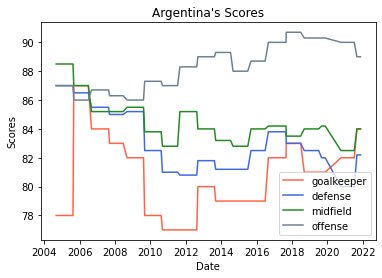

In [74]:
plt.figure()
plt.plot(argentina_scores['date'], 
         argentina_scores['goalkeeper_score'], 
         color='tomato',
         label='goalkeeper')
plt.plot(argentina_scores['date'], 
         argentina_scores['mean_defense_score'], 
         color='royalblue',
         label='defense')
plt.plot(argentina_scores['date'], 
         argentina_scores['mean_midfield_score'], 
         color='forestgreen',
         label='midfield')
plt.plot(argentina_scores['date'], 
         argentina_scores['mean_offense_score'], 
         color='slategrey',
         label='offense')
plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores")
plt.legend(loc='lower right')
#plt.xlim([dt.date(2004, 1, 1), dt.date(2022, 1, 1)])
plt.show()

[CHANGE] 
So we can see that the curves for defens, goalkeeper and midfield scores decrease and increase pretty much at the same time. Computing the differentials will also be beneficial. All of the above can be looped for all the teams that we are interested in

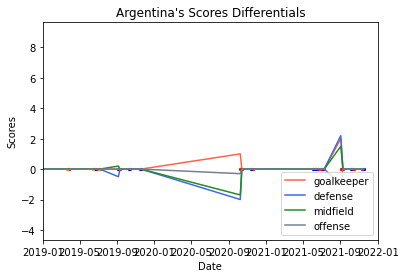

In [75]:
# Compute differentials
argentina_scores['rank_diff'] = argentina_scores['fifa_rank'].diff()
argentina_scores['goalkeeper_diff'] = argentina_scores['goalkeeper_score'].diff()
argentina_scores['defense_diff'] = argentina_scores['mean_defense_score'].diff()
argentina_scores['midfield_diff'] = argentina_scores['mean_midfield_score'].diff()
argentina_scores['offense_diff'] = argentina_scores['mean_offense_score'].diff()

plt.figure()
plt.plot(argentina_scores['date'], 
         argentina_scores['goalkeeper_diff'], 
         color='tomato',
         label='goalkeeper')
plt.plot(argentina_scores['date'], 
         argentina_scores['defense_diff'], 
         color='royalblue',
         label='defense')
plt.plot(argentina_scores['date'], 
         argentina_scores['midfield_diff'], 
         color='forestgreen',
         label='midfield')
plt.plot(argentina_scores['date'], 
         argentina_scores['offense_diff'], 
         color='slategrey',
         label='offense')
plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores Differentials")
plt.legend(loc='lower right')

# [CHANGE] We need to find out how the spikes above are correlated with wins/losses/draws. 
# We can add a win/loss/draw on the chart to see it.

plt.scatter(x=argentina_scores['date'].loc[argentina_scores['result']==1],
            y=argentina_scores['dummy'].loc[argentina_scores['result']==1],
            color='red',
            s=5)

plt.scatter(x=argentina_scores['date'].loc[argentina_scores['result']==0],
            y=argentina_scores['dummy'].loc[argentina_scores['result']==0],
            color='blue',
            s=5)

plt.scatter(x=argentina_scores['date'].loc[argentina_scores['result']==-1],
            y=argentina_scores['dummy'].loc[argentina_scores['result']==-1],
            color='orange',
            s=5)

plt.xlim([dt.date(2019, 1, 1), dt.date(2022, 1, 1)])
plt.show()

Not much can be concluded as Data is very messy. 2 options can be explored further. 1st is to check data on smaller time frames to see whether there is something interesting where the big spikes in the graph below has happened. On the other hand, it might also be interesting to check whether any spike is correlated to a loss/draw to a weaker team or a win to a stronger team. Maybe Argentina is not ideal for this analyses since it is top ranked. Also, our model is likely to predict that a stronger team will win on a weaker team (if it works well), therefore if we find out that this is actually true, then we may have a problem

In [76]:
# Finding when wins over stronger teams or draws/losses against weaker teams took place
# 2 options: either with avg difference in team score or with difference in rank. OR potentialli both conditions

argentina_scores_deviation_negative = argentina_scores.loc[((argentina_scores['result'] == 0|-1) & (argentina_scores['mean_team_diff']>0))]
#argentina_scores_deviation_negative = argentina_scores.loc[((argentina_scores['result'] == 0|-1) & (argentina_scores['rank_diff']<0))]

argentina_scores_deviation_negative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 13 to 175
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  22 non-null     object 
 1   fifa_rank             22 non-null     int64  
 2   result                22 non-null     int64  
 3   goalkeeper_score      22 non-null     float64
 4   mean_defense_score    22 non-null     float64
 5   mean_offense_score    22 non-null     float64
 6   mean_midfield_score   22 non-null     float64
 7   rank_team_diff        22 non-null     int64  
 8   goalkeeper_team_diff  22 non-null     float64
 9   defense_team_diff     22 non-null     float64
 10  offense_team_diff     22 non-null     float64
 11  midfield_team_diff    22 non-null     float64
 12  mean_team_diff        22 non-null     float64
 13  dummy                 22 non-null     int64  
 14  rank_diff             22 non-null     float64
 15  goalkeeper_diff       2

In [77]:
argentina_scores_deviation_positive = argentina_scores.loc[((argentina_scores['result'] == 1|0) & (argentina_scores['mean_team_diff']<0))]
#argentina_scores_deviation_positive = argentina_scores.loc[((argentina_scores['result'] == 1|0) & (argentina_scores['rank_diff']>0))]

argentina_scores_deviation_positive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 6 to 198
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  14 non-null     object 
 1   fifa_rank             14 non-null     int64  
 2   result                14 non-null     int64  
 3   goalkeeper_score      14 non-null     float64
 4   mean_defense_score    14 non-null     float64
 5   mean_offense_score    14 non-null     float64
 6   mean_midfield_score   14 non-null     float64
 7   rank_team_diff        14 non-null     int64  
 8   goalkeeper_team_diff  14 non-null     float64
 9   defense_team_diff     14 non-null     float64
 10  offense_team_diff     14 non-null     float64
 11  midfield_team_diff    14 non-null     float64
 12  mean_team_diff        14 non-null     float64
 13  dummy                 14 non-null     int64  
 14  rank_diff             14 non-null     float64
 15  goalkeeper_diff       14

Next step is plotting differentials between the matches located in the above dataframes

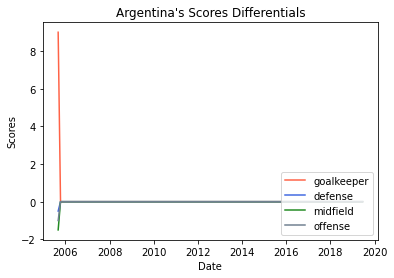

In [78]:
# Produce plots

plt.figure()
plt.plot(argentina_scores_deviation_negative['date'], 
         argentina_scores_deviation_negative['goalkeeper_diff'], 
         color='tomato',
         label='goalkeeper')
plt.plot(argentina_scores_deviation_negative['date'], 
         argentina_scores_deviation_negative['defense_diff'], 
         color='royalblue',
         label='defense')
plt.plot(argentina_scores_deviation_negative['date'], 
         argentina_scores_deviation_negative['midfield_diff'], 
         color='forestgreen',
         label='midfield')
plt.plot(argentina_scores_deviation_negative['date'], 
         argentina_scores_deviation_negative['offense_diff'], 
         color='slategrey',
         label='offense')
plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores Differentials")
plt.legend(loc='lower right')
plt.show()

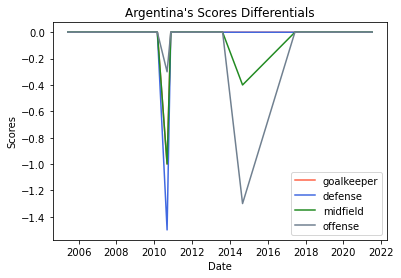

In [79]:
plt.figure()
plt.plot(argentina_scores_deviation_positive['date'], 
         argentina_scores_deviation_positive['goalkeeper_diff'], 
         color='tomato',
         label='goalkeeper')
plt.plot(argentina_scores_deviation_positive['date'], 
         argentina_scores_deviation_positive['defense_diff'], 
         color='royalblue',
         label='defense')
plt.plot(argentina_scores_deviation_positive['date'], 
         argentina_scores_deviation_positive['midfield_diff'], 
         color='forestgreen',
         label='midfield')
plt.plot(argentina_scores_deviation_positive['date'], 
         argentina_scores_deviation_positive['offense_diff'], 
         color='slategrey',
         label='offense')
plt.xlabel('Date')
plt.ylabel('Scores')
plt.title("Argentina's Scores Differentials")
plt.legend(loc='lower right')
plt.show()

2 observations: 1. Not all the spikes are highlighted. 2. Where I was expecting mainly positive variations I got negatives. So this is not the way.

Since no specific trend is found and big surges/drops in the scores are identified, it is sensible to fit to the following 6 months for engineering the test set the line of best fit, intended as the derivative. Since matches that are not recent are less relevant to the team performance in 2022, the derivative has been computed only over the last 2.5 years

In [80]:
ref_date = dt.date(2019, 1, 1)

argentina_scores.drop(argentina_scores[argentina_scores['date']<ref_date].index, inplace=True)

argentina_scores.head()

,date,fifa_rank,result,goalkeeper_score,mean_defense_score,mean_offense_score,mean_midfield_score,rank_team_diff,goalkeeper_team_diff,defense_team_diff,offense_team_diff,midfield_team_diff,mean_team_diff,dummy,rank_diff,goalkeeper_diff,defense_diff,midfield_diff,offense_diff
173,2019-03-22,11,-1,81.0,82.5,90.3,84.0,-21,8.0,8.3,13.0,8.8,9.525,0,-1.0,0.0,0.0,0.0,0.0
174,2019-03-26,11,1,81.0,82.5,90.3,84.0,-32,4.0,3.7,12.3,5.5,6.375,0,0.0,0.0,0.0,0.0,0.0
175,2019-06-15,11,-1,81.0,82.5,90.3,84.0,-2,3.0,2.3,8.0,1.8,3.775,0,0.0,0.0,0.0,0.0,0.0
176,2019-06-19,11,0,81.0,82.5,90.3,84.0,-25,4.0,6.5,13.6,6.5,7.650,0,0.0,0.0,0.0,0.0,0.0
177,2019-06-28,11,1,81.0,82.5,90.3,84.0,-22,8.0,8.3,13.0,8.8,9.525,0,0.0,0.0,0.0,0.0,0.0


Just for testing on 1 team, for easier coding

In [81]:
derivative = pd.DataFrame()
date_diff = pd.DataFrame()

feature_list = ['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score']

score_diff = []
date_diff['date'] = argentina_scores['date'].diff(periods=(len(argentina_scores)-1)).reset_index(drop=True)
date_diff_num = date_diff.at[(len(argentina_scores)-1),'date']

for i in feature_list:
    derivative[i] = argentina_scores[i].diff(periods=(len(argentina_scores)-1)).reset_index(drop=True)
    j = derivative.at[(len(argentina_scores)-1),i]
    score_diff.append(j)

In [82]:
def team_score_derivative(team, ref_date):
    
    # Fetch all rows containing specific team
    team_data_tot = clean_data2.loc[((clean_data2['home_team'] == team) | (clean_data2['away_team'] == team))]
    
    
    team_data_tot.loc[:,('is_home')] = team_data_tot.loc[:,('home_team')].map({team:1}, na_action='ignore')
    team_data_tot.loc[:,('is_home')] = team_data_tot.loc[:,('is_home')].replace(np.nan, 0)
    
    # Build 2 separate DFs for argentina as home and away team, drop useless columns and rename columns with same names  
    team_scores_home = team_data_tot.loc[team_data_tot['is_home'] == 1]

    # Drop useless columns
    team_scores_home = team_scores_home.drop(columns=['home_team',
                                                      'away_team',
                                                      'away_team_fifa_rank',
                                                      'tournament',
                                                      'neutral_location',
                                                      'away_team_goalkeeper_score',
                                                      'away_team_mean_defense_score',
                                                      'away_team_mean_offense_score',
                                                      'away_team_mean_midfield_score',
                                                      'is_home'])
    # Rename columns so that 2 DFs can be merged
    team_scores_home = team_scores_home.rename(columns={'home_team_fifa_rank':'fifa_rank',
                                                        'home_team_result':'result',
                                                        'home_team_goalkeeper_score':'goalkeeper_score',
                                                        'home_team_mean_defense_score':'mean_defense_score',
                                                        'home_team_mean_offense_score':'mean_offense_score',
      
                                                        'home_team_mean_midfield_score':'mean_midfield_score'})
    # Do the same for Away DF
    team_scores_away = team_data_tot.loc[team_data_tot['is_home'] == 0]

    
    team_scores_away = team_scores_away.drop(columns=['home_team',
                                                      'away_team',
                                                      'home_team_fifa_rank',
                                                      'tournament',
                                                      'neutral_location',
                                                      'home_team_goalkeeper_score',
                                                      'home_team_mean_defense_score',
                                                      'home_team_mean_offense_score',
                                                      'home_team_mean_midfield_score',
                                                      'is_home'])

    team_scores_away = team_scores_away.rename(columns={'away_team_fifa_rank':'fifa_rank',
                                                        'home_team_result':'result',
                                                        'away_team_goalkeeper_score':'goalkeeper_score',
                                                        'away_team_mean_defense_score':'mean_defense_score',
                                                        'away_team_mean_offense_score':'mean_offense_score',
                                                        'away_team_mean_midfield_score':'mean_midfield_score'})

    # Change scores for away DF to the same structure as home DF
    team_scores_away['result'] = team_scores_away['result'].map({0:0, 1:-1, -1:1})
    
    # Merge DFs
    team_scores = pd.concat([team_scores_home, team_scores_away]).sort_index() # Merge 2 DFs
    team_scores.reset_index(inplace=True, drop=True)
    
    # Drop matches before reference date
    team_scores.drop(team_scores[team_scores['date']<ref_date].index, inplace=True)

    
    # Allocate variables for deriivatives computation
    derivative = pd.DataFrame()
    date_diff = pd.DataFrame()

    feature_list = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])

    score_diff = np.array([])
    date_diff['date'] = team_scores['date'].diff(periods=(len(team_scores)-1)).reset_index(drop=True)
    if len(team_scores) != 0:
        date_diff_num = ([date_diff.at[(len(team_scores)-1),'date']])
    else: date_diff_num = None

    for i in feature_list:
        derivative[i] = team_scores[i].diff(periods=(len(team_scores)-1)).reset_index(drop=True)
        j = derivative.at[(len(team_scores)-1),i].round(2)
        score_diff = np.append(score_diff, j)

    return (score_diff, date_diff_num)
        

Iterate function over all teams

In [83]:
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

ind = np.argwhere(countries_22=='Qatar')
countries_22_clean = np.delete(countries_22, ind)   # drop Qatar

pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

for i in countries_22_clean:
    
    # print(i)
    score_diff_s, date_diff_num_s = team_score_derivative(i, ref_date)
    # print(score_diff_s, date_diff_num_s)
    # print(score_diff_s.shape)
    score_diff_all_teams = np.vstack([score_diff_all_teams,  score_diff_s])
    date_diff_all_teams = np.vstack([date_diff_all_teams, date_diff_num_s]) 

date_diff_all_teams_df = pd.DataFrame(date_diff_all_teams, columns=['deltas'])
date_diff_all_teams_df = date_diff_all_teams_df.iloc[1: , :]

date_diff_all_teams_df['days'] = (date_diff_all_teams_df['deltas'] / np.timedelta64(1, 'D')).astype(int)
date_diff_all_teams_df = date_diff_all_teams_df.drop(columns=['deltas'])
date_diff_all_teams_df.head()

,days
1,970
2,893
3,971
4,969
5,886


Here ends work on prediction set. From now, only test set.

Fetch all other features from big dataset (i.e., Shootout, Neutral Location)

In [84]:
# Load international matches dataset, only for 2022 onwards to avoid huge DF

international_matches = pd.read_csv('dataset/international_matches.csv')
international_matches['date'] = pd.to_datetime(international_matches['date']).dt.date

# loading test_set [2ND LOAD,CONSIDER WHICH ONE TO DELETE]
test_set = pd.read_csv('dataset/test_set.csv')
test_set['date'] = pd.to_datetime(test_set['date']).dt.date

In [85]:
# This has only the purpose of making the df lighter, as it is huge
ref_date = dt.date(2022, 1, 1)
international_matches.drop(international_matches[international_matches['date']<ref_date].index, inplace=True)

In [86]:
# Drop columns for scores, as we need to engineer them and using them is not admitted
international_matches = international_matches[['date','home_team','away_team','shoot_out','neutral_location','home_team_result']]
international_matches.head()

,date,home_team,away_team,shoot_out,neutral_location,home_team_result
23350,2022-01-02,Gabon,Burkina Faso,No,True,Lose
23351,2022-01-02,Sudan,Zimbabwe,No,True,Draw
23352,2022-01-03,Rwanda,Guinea,No,False,Win
23353,2022-01-04,Mauritania,Gabon,No,True,Draw
23354,2022-01-05,Algeria,Ghana,No,True,Win


In [87]:
# merge 2 DFs according to test_set columns. RUN THIS ONLY ONCE, IF YOU WANT TO RUN AGAIN, REDEFINE TEST_SET FIRST
test_set = test_set.merge(international_matches, how='inner', on=['date','home_team','away_team','home_team_result'])
test_set

,date,home_team,away_team,home_team_result,shoot_out,neutral_location
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True
1,2022-01-05,Algeria,Ghana,Win,No,True
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False
3,2022-01-10,Senegal,Zimbabwe,Win,No,True
4,2022-01-10,Morocco,Ghana,Win,No,True
...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,No,False
243,2022-06-14,Romania,Montenegro,Lose,No,False
244,2022-06-14,Chile,Ghana,Lose,Yes,True
245,2022-06-14,Japan,Tunisia,Lose,No,False


In [88]:
countries_test_set = np.unique(test_set[['home_team', 'away_team']].values)
countries_test_set

array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso',
       'Cabo Verde', 'Cameroon', 'Canada', 'Chile', 'China PR',
       'Colombia', 'Congo', 'Congo DR', 'Costa Rica', 'Croatia',
       'Curaçao', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Denmark',
       'Ecuador', 'Egypt', 'England', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guinea',
       'Guinea-Bissau', 'Honduras', 'Hungary', 'IR Iran', 'Iceland',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Korea Republic', 'Kosovo',
       'Luxembourg', 'Madagascar', 'Mali', 'Mexico', 'Montenegro',
       'Morocco', 'Netherlands', 'New Zealand', 'Nigeria',
       'North Macedonia', 'Northern Ireland', 'Norway', 'Panama',
       'Paraguay', 'Peru', 'Poland', 'Portugal', 'Republic of Ireland',
       'Romania', 'Saudi Arabia', 'Scotland', 'Senegal', '

In [89]:
# Initialise starting features
# initialise remaining features
test_set = test_set.assign(home_team_fifa_rank=np.zeros(len(test_set), dtype=int))
test_set = test_set.assign(away_team_fifa_rank=np.zeros(len(test_set), dtype=int))
test_set = test_set.assign(home_team_goalkeeper_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(away_team_goalkeeper_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(home_team_mean_defense_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(home_team_mean_offense_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(home_team_mean_midfield_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(away_team_mean_defense_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(away_team_mean_offense_score=np.zeros(len(test_set), dtype=float))
test_set = test_set.assign(away_team_mean_midfield_score=np.zeros(len(test_set), dtype=float))

test_set

,date,home_team,away_team,home_team_result,shoot_out,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-05,Algeria,Ghana,Win,No,True,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-10,Senegal,Zimbabwe,Win,No,True,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-10,Morocco,Ghana,Win,No,True,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,No,False,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,2022-06-14,Romania,Montenegro,Lose,No,False,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,2022-06-14,Chile,Ghana,Lose,Yes,True,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,2022-06-14,Japan,Tunisia,Lose,No,False,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# function to update missing prediction data with last match outcomes
def update_test_data(country):
    last_home = date_data.query("home_team == @country").tail(1)
    last_away = date_data.query("away_team == @country").tail(1)
   
    
    if last_home['date'].item() > last_away['date'].item():

        test_set['home_team_fifa_rank'] = np.where(test_set['home_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    test_set['home_team_fifa_rank'])
        test_set['home_team_goalkeeper_score'] = np.where(test_set['home_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           test_set['home_team_goalkeeper_score'])
        test_set['home_team_mean_defense_score'] = np.where(test_set['home_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             test_set['home_team_mean_defense_score'])
        test_set['home_team_mean_offense_score'] = np.where(test_set['home_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             test_set['home_team_mean_offense_score'])
        test_set['home_team_mean_midfield_score'] = np.where(test_set['home_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              test_set['home_team_mean_midfield_score'])

        test_set['away_team_fifa_rank'] = np.where(test_set['away_team'] == country, \
                                                    last_home['home_team_fifa_rank'].item(), \
                                                    test_set['away_team_fifa_rank'])
        test_set['away_team_goalkeeper_score'] = np.where(test_set['away_team'] == country, \
                                                           last_home['home_team_goalkeeper_score'].item(), \
                                                           test_set['away_team_goalkeeper_score'])
        test_set['away_team_mean_defense_score'] = np.where(test_set['away_team'] == country, \
                                                             last_home['home_team_mean_defense_score'].item(), \
                                                             test_set['away_team_mean_defense_score'])
        test_set['away_team_mean_offense_score'] = np.where(test_set['away_team'] == country, \
                                                             last_home['home_team_mean_offense_score'].item(), \
                                                             test_set['away_team_mean_offense_score'])
        test_set['away_team_mean_midfield_score'] = np.where(test_set['away_team'] == country, \
                                                              last_home['home_team_mean_midfield_score'].item(), \
                                                              test_set['away_team_mean_midfield_score'])
        
    else:
        test_set['home_team_fifa_rank'] = np.where(test_set['home_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    test_set['home_team_fifa_rank'])
        test_set['home_team_goalkeeper_score'] = np.where(test_set['home_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           test_set['home_team_goalkeeper_score'])
        test_set['home_team_mean_defense_score'] = np.where(test_set['home_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             test_set['home_team_mean_defense_score'])
        test_set['home_team_mean_offense_score'] = np.where(test_set['home_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             test_set['home_team_mean_offense_score'])
        test_set['home_team_mean_midfield_score'] = np.where(test_set['home_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              test_set['home_team_mean_midfield_score'])

        test_set['away_team_fifa_rank'] = np.where(test_set['away_team'] == country, \
                                                    last_away['away_team_fifa_rank'].item(), \
                                                    test_set['away_team_fifa_rank'])
        test_set['away_team_goalkeeper_score'] = np.where(test_set['away_team'] == country, \
                                                           last_away['away_team_goalkeeper_score'].item(), \
                                                           test_set['away_team_goalkeeper_score'])
        test_set['away_team_mean_defense_score'] = np.where(test_set['away_team'] == country, \
                                                             last_away['away_team_mean_defense_score'].item(), \
                                                             test_set['away_team_mean_defense_score'])
        test_set['away_team_mean_offense_score'] = np.where(test_set['away_team'] == country, \
                                                             last_away['away_team_mean_offense_score'].item(), \
                                                             test_set['away_team_mean_offense_score'])
        test_set['away_team_mean_midfield_score'] = np.where(test_set['away_team'] == country, \
                                                              last_away['away_team_mean_midfield_score'].item(), \
                                                              test_set['away_team_mean_midfield_score'])


In [91]:
# Execute above function for all countries. DO NOT RUN TWICE
for i in countries_test_set:
    
    if i != 'Suriname':
        update_test_data(i)
        
test_set.to_csv('test_out_2.csv')

In [92]:
# Calculate differentials for countries in test_set
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

for i in countries_test_set:
    
    if i != 'Suriname':
               
        score_diff_s, date_diff_num_s = team_score_derivative(i, ref_date)

        score_diff_all_teams = np.vstack([score_diff_all_teams,  score_diff_s])
        date_diff_all_teams  = np.vstack([date_diff_all_teams, date_diff_num_s]) 

        
score_diff_all_teams_df = pd.DataFrame(score_diff_all_teams, columns=['fifa_rank',
                                                                      'goalkeeper_score',
                                                                      'mean_defense_score',
                                                                      'mean_offense_score',
                                                                      'mean_midfield_score']).round(2).iloc[1: , :].astype(float)

date_diff_all_teams_df = pd.DataFrame(date_diff_all_teams, columns=['deltas'])
date_diff_all_teams_df = date_diff_all_teams_df.iloc[1: , :]

date_diff_all_teams_df['days'] = (date_diff_all_teams_df['deltas'] / np.timedelta64(1, 'D')).astype(int)
date_diff_all_teams_df = date_diff_all_teams_df.drop(columns=['deltas'])

date_diff_all_teams_df

,days
1,966
2,998
3,644
4,970
5,967
...,...
87,252
88,893
89,970
90,972


To calculate the deltas, the dates of the first match for every team in test_set needs to be saved in an array

In [93]:
first_date = np.array([])
for i in countries_test_set:
    team_set = test_set.loc[((test_set['home_team'] == i) | (test_set['away_team'] == i))]
    team_date = team_set['date'].head(1)
    first_date = np.append(first_date, team_date)

Now we need to add the derivative to all the scores filled in the test_set

In [94]:
def update_scores_derivatives(country, j):

    #j: Counts teams, i.e. rows in score_diff_all_teams
    
    dates_home = pd.DataFrame([])
    dates_home['date'] = test_set['date'].loc[(test_set['home_team']==country)].reset_index(drop=True)
    dates_home['deltas'] = dates_home['date'].diff()
    dates_home = dates_home.iloc[1: , :]
    dates_home['days'] = (dates_home['deltas'] / np.timedelta64(1, 'D')).astype(int)
    dates_home = dates_home.drop(columns=['deltas','date'])
    
    if len(dates_home!=0):

        home_team_index = test_set.index[test_set['home_team']==country].tolist()
        
        date_diff_this_team = int(date_diff_all_teams_df.loc[j,'days'])

        for k in [home_team_index]:
            a = 1 # Counts progress in dates_home
            dates_home_s = int(dates_home.loc[a,'days'])

            test_set.loc[k,'home_team_fifa_rank']           = (test_set.loc[k,'home_team_fifa_rank'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,0])*(dates_home_s/date_diff_this_team))
            test_set.loc[k,'home_team_goalkeeper_score']    = (test_set.loc[k,'home_team_goalkeeper_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,1])*(dates_home_s/date_diff_this_team))
            test_set.loc[k,'home_team_mean_defense_score']  = (test_set.loc[k,'home_team_mean_defense_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,2])*(dates_home_s/date_diff_this_team))
            test_set.loc[k,'home_team_mean_offense_score']  = (test_set.loc[k,'home_team_mean_offense_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,3])*(dates_home_s/date_diff_this_team))
            test_set.loc[k,'home_team_mean_midfield_score'] = (test_set.loc[k,'home_team_mean_midfield_score'] + 
                                                               (score_diff_all_teams_df.iloc[j-1,4])*(dates_home_s/date_diff_this_team))
            a += 1
        else : None
    
    
    dates_away = pd.DataFrame([])
    dates_away['date'] = test_set['date'].loc[(test_set['away_team']==country)].reset_index(drop=True)
    dates_away['deltas'] = dates_away['date'].diff()
    dates_away = dates_away.iloc[1: , :]
    dates_away['days'] = (dates_away['deltas'] / np.timedelta64(1, 'D')).astype(int)
    dates_away = dates_away.drop(columns=['deltas','date'])
   
    if len(dates_away!=0):
        
        away_team_index = test_set.index[test_set['away_team']==country].tolist().pop(0)   
        date_diff_this_team = int(date_diff_all_teams_df.loc[j,'days']) # I think I can delete this line

        for k in [away_team_index]:
            a = 1 # Counts progress in dates_home
            dates_away_s = int(dates_away.loc[a,'days'])

            test_set.loc[k,'away_team_fifa_rank']     = (test_set.loc[k,'away_team_fifa_rank'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,0])*(dates_away_s/date_diff_this_team))
            test_set.loc[k,'away_team_goalkeeper_score']    = (test_set.loc[k,'away_team_goalkeeper_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,1])*(dates_away_s/date_diff_this_team))
            test_set.loc[k,'away_team_mean_defense_score']  = (test_set.loc[k,'away_team_mean_defense_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,2])*(dates_away_s/date_diff_this_team))
            test_set.loc[k,'away_team_mean_offense_score']  = (test_set.loc[k,'away_team_mean_offense_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,3])*(dates_away_s/date_diff_this_team))
            test_set.loc[k,'away_team_mean_midfield_score'] = (test_set.loc[k,'away_team_mean_midfield_score'] + 
                                                         (score_diff_all_teams_df.iloc[j-1,4])*(dates_away_s/date_diff_this_team))
            a += 1
    else: None
        

In [95]:
j = 1
for i in countries_test_set:
    
    if i != 'Suriname':
        
        update_scores_derivatives(i, j)
        j += 1
        
    else: None

# Save w/ different name to distinguish from pred 
test_set_final = test_set
test_set_final

,date,home_team,away_team,home_team_result,shoot_out,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-01-02,Gabon,Burkina Faso,Lose,No,True,85.955224,61.023569,70.589254,73.054994,70.222388,70.205970,75.403731,69.503928,71.689787,66.972503
1,2022-01-05,Algeria,Ghana,Win,No,True,28.922846,52.000000,78.914830,74.025853,78.066533,81.083166,77.767134,75.500000,75.989659,78.202068
2,2022-01-09,Cameroon,Burkina Faso,Win,No,False,54.027088,61.000000,66.900677,73.000000,76.796388,77.688262,75.001806,69.500000,71.700000,67.000000
3,2022-01-10,Senegal,Zimbabwe,Win,No,True,19.983402,118.000000,83.033195,70.875000,78.992531,80.698755,79.003320,65.000000,72.300000,70.875000
4,2022-01-10,Morocco,Ghana,Win,No,True,26.819374,52.000000,82.393542,74.000000,81.388900,81.991221,76.018971,75.500000,76.000000,78.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-06-14,Bosnia and Herzegovina,Finland,Win,No,False,61.103896,60.000000,75.988012,83.000000,74.192008,76.993207,77.990010,70.000000,72.300000,73.500000
243,2022-06-14,Romania,Montenegro,Lose,No,False,42.294606,73.000000,76.919087,65.000000,73.313900,73.651452,75.040456,76.200000,74.700000,68.200000
244,2022-06-14,Chile,Ghana,Lose,Yes,True,24.676411,52.000000,79.000000,74.000000,75.561492,76.497077,77.997077,75.500000,76.000000,78.200000
245,2022-06-14,Japan,Tunisia,Lose,No,False,25.879397,29.000000,73.005025,72.366667,75.195980,74.993467,77.489950,70.800000,72.300000,74.000000


Now that all the test set has been successfully built, it is necerssary to buold the features in the prediction set, i.e., world_cup_2022

In [96]:
test_set = pred_data1
test_set

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,55,0.000000,71.000000,0.0,0.0,0.0,73.5,76.0,74.5
1,2022-11-21,Senegal,Netherlands,0,1,20,11,83.000000,81.000000,79.0,80.7,79.0,85.2,83.0,83.5
2,2022-11-21,England,IR Iran,0,1,5,22,83.000000,73.000000,85.0,88.0,84.0,69.0,75.3,69.0
3,2022-11-21,USA,Wales,0,1,12,19,77.000000,74.000000,75.8,77.7,75.8,75.0,73.0,78.5
4,2022-11-22,France,Australia,0,1,3,34,87.000000,77.000000,84.2,88.3,86.8,72.0,72.3,73.5
5,2022-11-22,Denmark,Tunisia,0,1,10,29,85.000000,72.366667,80.2,77.7,80.2,70.8,72.3,74.0
6,2022-11-22,Mexico,Poland,0,1,14,23,80.000000,87.000000,76.8,82.7,78.2,75.2,84.7,75.8
7,2022-11-22,Argentina,Saudi Arabia,0,1,6,48,84.000000,70.000000,82.2,89.0,84.0,72.8,67.7,72.8
8,2022-11-23,Belgium,Canada,0,1,1,48,89.000000,76.000000,80.8,85.7,85.5,69.2,73.0,78.0
9,2022-11-23,Spain,Costa Rica,0,1,7,45,84.000000,88.000000,86.5,85.0,86.0,71.5,70.3,69.2


In [97]:
# Calculate differentials for countries in test_set
ref_date = dt.date(2019, 1, 1)

score_diff_all_teams = np.array(['fifa_rank','goalkeeper_score','mean_defense_score','mean_offense_score','mean_midfield_score'])
date_diff_all_teams = np.array(['date'])

pd.options.mode.chained_assignment = None  # default='warn', avoids annoing warnings

for i in countries_22_clean:
    
    if i != 'Qatar':
               
        score_diff_s, date_diff_num_s = team_score_derivative(i, ref_date)

        score_diff_all_teams = np.vstack([score_diff_all_teams,  score_diff_s])
        date_diff_all_teams  = np.vstack([date_diff_all_teams, date_diff_num_s]) 

        
score_diff_all_teams_df = pd.DataFrame(score_diff_all_teams, columns=['fifa_rank',
                                                                      'goalkeeper_score',
                                                                      'mean_defense_score',
                                                                      'mean_offense_score',
                                                                      'mean_midfield_score']).round(2).iloc[1: , :].astype(float)

date_diff_all_teams_df = pd.DataFrame(date_diff_all_teams, columns=['deltas'])
date_diff_all_teams_df = date_diff_all_teams_df.iloc[1: , :]

date_diff_all_teams_df['days'] = (date_diff_all_teams_df['deltas'] / np.timedelta64(1, 'D')).astype(int)
date_diff_all_teams_df = date_diff_all_teams_df.drop(columns=['deltas'])

date_diff_all_teams_df

,days
1,970
2,893
3,971
4,969
5,886
6,881
7,1018
8,966
9,970
10,971


In [98]:
first_date = np.array([])
for i in countries_22_clean:
    team_set = test_set.loc[((test_set['home_team'] == i) | (test_set['away_team'] == i))]
    team_date = team_set['date'].head(1)
    first_date = np.append(first_date, team_date)

In [99]:
j = 1
for i in countries_22_clean:
    if i != 'Qatar':
        
        update_scores_derivatives(i, j)
        j += 1
        
    else: None

test_set.head()

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0.000000,54.984552,0.000000,70.984552,0.000000,0.000000,0.000000,73.497425,76.001545,74.494851
1,2022-11-21,Senegal,Netherlands,0,1,20.000000,11.000000,83.000000,81.000000,79.000000,80.700000,79.000000,85.200000,83.000000,83.500000
2,2022-11-21,England,IR Iran,0,1,5.000000,21.971774,83.000000,73.004032,85.010352,88.011180,84.007453,69.000000,75.308065,68.991935
3,2022-11-21,USA,Wales,0,1,12.000000,19.000000,77.000000,74.000000,75.800000,77.700000,75.800000,75.000000,73.000000,78.500000
4,2022-11-22,France,Australia,0,1,3.004137,33.968645,86.995863,76.995521,84.197518,88.319028,86.794209,71.994625,72.311646,73.489698


# [END PROJECT]